In [1]:
!pip install -q tfds-nightly

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

#training을 위한 inputdata, 파이프라인 설정

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\kbs77\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

#"Hello TensorFlow"를 정수 인코딩

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [7]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

#각 token이 어떻게 인코딩 되었는지 보여주기 위함.

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

**RNN Model**

embedding layer + biLSTM

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 755s 2s/step - loss: 0.6805 - accuracy: 0.5173 - val_loss: 0.4429 - val_accuracy: 0.8036
Epoch 2/10
391/391 [==============================] - 756s 2s/step - loss: 0.3660 - accuracy: 0.8408 - val_loss: 0.3839 - val_accuracy: 0.8005
Epoch 3/10
391/391 [==============================] - 746s 2s/step - loss: 0.2593 - accuracy: 0.8970 - val_loss: 0.3167 - val_accuracy: 0.8594
Epoch 4/10
391/391 [==============================] - 754s 2s/step - loss: 0.2100 - accuracy: 0.9222 - val_loss: 0.3427 - val_accuracy: 0.8646
Epoch 5/10
391/391 [==============================] - 758s 2s/step - loss: 0.1766 - accuracy: 0.9353 - val_loss: 0.3326 - val_accuracy: 0.8740
Epoch 6/10
391/391 [==============================] - 763s 2s/step - loss: 0.1585 - accuracy: 0.9454 - val_loss: 0.3444 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 772s 2s/step - loss: 0.1411 - accuracy: 0.9527 - val_loss: 0.3920 - val_accuracy: 0.8542

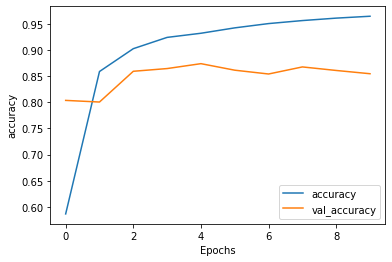

In [19]:
plot_graphs(history, 'accuracy')

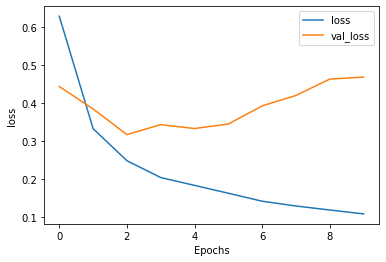

In [20]:
plot_graphs(history, 'loss')

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

# 1st LSTM에서 return_sequences=True : layer의 output을 다음 layer로 그대로 넘겨줌
# 2nd LSTM은 return_sequences=False(Default) : 마지막 계산 값만 output으로 넘김

padding을 했을때와 padding을 하지 않았을 때의 predictions값을 비교

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 275s 700ms/step - loss: 0.5250 - accuracy: 0.7526
Test Loss: 0.5250032544136047
Test Accuracy: 0.752560019493103


In [15]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [16]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [17]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.10976848]]


In [18]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.17829919]]
